In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import urllib.request
import matplotlib as mpl
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
tf.get_logger().setLevel('INFO')
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_visible_devices(devices=gpus[1], device_type='GPU')
tf.config.experimental.set_memory_growth(device=gpus[1], enable=True)
import urllib
from dataclasses import dataclass
# import tensorflowjs as tfjs
# import tensorflow_decision_forests as tfdf
import json
from tqdm import tqdm
import seaborn as sns
import sys
np.random.seed(0)
urllib.request.urlretrieve('https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf', 'IBMPlexMono-Regular.ttf')
fe = font_manager.FontEntry(
    fname='IBMPlexMono-Regular.ttf',
    name='plexmono')
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update({'axes.facecolor':'#f5f4e9', 
            'grid.color' : '#AAAAAA', 
            'axes.edgecolor':'#333333', 
            'figure.facecolor':'#FFFFFF', 
            'axes.grid': False,
            'axes.prop_cycle':   plt.cycler('color', plt.cm.Dark2.colors),
            'font.family': fe.name,
            'figure.figsize': (3.5,3.5 / 1.2),
            'ytick.left': True,
            'xtick.bottom': True   
           })

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [3]:
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-dashboard/raw/master/ml/data/hemo-positive.npz",
    "positive.npz",
)
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-dashboard/raw/master/ml/data/hemo-negative.npz",
    "negative.npz",
)

with np.load("positive.npz") as r:
    pos_data = r[list(r.keys())[0]]
with np.load("negative.npz") as r:
    neg_data = r[list(r.keys())[0]]

In [4]:
def decoder(seq_vector):
  alphabet = ['A','R','N','D','C','Q','E','G','H','I', 'L','K','M','F','P','S','T','W','Y','V']
  seq = []
  for i, index in enumerate(seq_vector.astype('int')):
    if index == 0:
      break
    seq.append(alphabet[index-1])
  seq = ''.join(seq)
  return seq

In [5]:
def counts_aa(vec):
    counts =  tf.histogram_fixed_width(vec, [0, 20], nbins=21)[1:]
    return counts /tf.reduce_sum(counts)


In [6]:
# Modified code from https://github.com/alexarnimueller/modlAMP/blob/master/modlamp/sequences.py

from itertools import cycle

from modlamp.core import BaseSequence, ngrams_apd
from modlamp.sequences import Centrosymmetric, Helices, Kinked, Oblique, Random

class MixedLibrary(BaseSequence):
    """Class for holding a virtual peptide library.
    This class :class:`MixedLibrary` incorporates methods to generate a virtual peptide library composed out of different
    sub-libraries. The available library subtypes are all from the classes :class:`Centrosymmetric`, :class:`Helices`,
    :class:`Kinked`, :class:`Oblique` or :class:`Random`.
    """
    
    def __init__(self, seqnum, centrosymmetric=1, centroasymmetric=1, helix=1, kinked=1, oblique=1, rand=1, randAMP=1,
                 randAMPnoCM=1, lenmin=7, lenmax=28):
        """initializing method of the class :class:`MixedLibrary`. Except from **number**, all other parameters are
        ratios of sequences of the given sequence class.
        :param seqnum: {int} number of sequences to be generated
        :param centrosymmetric: ratio of symmetric centrosymmetric sequences in the library
        :param centroasymmetric: ratio of asymmetric centrosymmetric sequences in the library
        :param helix: ratio of amphipathic helical sequences in the library
        :param kinked: ratio of kinked amphipathic helical sequences in the library
        :param oblique: ratio of oblique oriented amphipathic helical sequences in the library
        :param rand: ratio of random sequneces in the library
        :param randAMP: ratio of random sequences with APD2 amino acid distribution in the library
        :param randAMPnoCM: ratio of random sequences with APD2 amino acid distribution without Cys and Met in the library
        .. warning::
            If duplicate sequences are created, these are removed during the creation process. It is therefore quite
            probable that you will not get the exact size of library that you entered as the parameter **number**. If you
            generate a small library, it can also happen that the size is bigger than expected, because ratios are rounded.
        """
        super(MixedLibrary, self).__init__(seqnum)  # inherit methods and some attributes from BaseSequence
        self.libsize = int(seqnum)
        norm = float(sum((centrosymmetric, centroasymmetric, helix, kinked, oblique, rand, randAMP, randAMPnoCM)))
        self.ratios = {'sym': float(centrosymmetric) / norm, 'asy': float(centroasymmetric) / norm,
                       'hel': float(helix) / norm, 'knk': float(kinked) / norm, 'obl': float(oblique) / norm,
                       'ran': float(rand) / norm, 'AMP': float(randAMP) / norm, 'nCM': float(randAMPnoCM) / norm}
        self.nums = {'sym': int(round(float(self.libsize) * self.ratios['sym'], ndigits=0)),
                     'asy': int(round(float(self.libsize) * self.ratios['asy'], ndigits=0)),
                     'hel': int(round(float(self.libsize) * self.ratios['hel'], ndigits=0)),
                     'knk': int(round(float(self.libsize) * self.ratios['knk'], ndigits=0)),
                     'obl': int(round(float(self.libsize) * self.ratios['obl'], ndigits=0)),
                     'ran': int(round(float(self.libsize) * self.ratios['ran'], ndigits=0)),
                     'AMP': int(round(float(self.libsize) * self.ratios['AMP'], ndigits=0)),
                     'nCM': int(round(float(self.libsize) * self.ratios['nCM'], ndigits=0))}
        self.lenmin = lenmin
        self.lenmax = lenmax
    
    def generate_sequences(self):
        """This method generates a virtual sequence library with the subtype ratios initialized in class :class:`MixedLibrary()`.
        All sequences are between 7 and 28 amino acids in length.
        :return: a virtual library of sequences in the attribute :py:attr:`sequences`, the sub-library class names in
            :py:attr:`names`, the number of sequences generated for each class in :py:attr:`nums` and the library size in
            :py:attr:`libsize`.
        :Example:
        >>> lib = MixedLibrary(10000, centrosymmetric=5, centroasymmetric=5, helix=3, kinked=3, oblique=2, rand=10,
        randAMP=10,randAMPnoCM=5)
        >>> lib.generate_sequences()
        >>> lib.libsize  # as duplicates were present, the library does not have the size that was sepecified
        9126
        >>> lib.sequences
        ['RHTHVAGSWYGKMPPSPQTL','MRIKLRKIPCILAC','DGINKEVKDSYGVFLK','LRLYLRLGRVWVRG','GKLFLKGGKLFLKGGKLFLKG',...]
        >>> lib.nums
        {'AMP': 2326,
        'asy': 1163,
        'hel': 698,
        'knk': 698,
        'nCM': 1163,
        'obl': 465,
        'ran': 2326,
        'sym': 1163}
        """
        Cs = Centrosymmetric(self.nums['sym'])
        Cs.generate_sequences(symmetry='symmetric')
        Ca = Centrosymmetric(self.nums['asy'])
        Ca.generate_sequences(symmetry='asymmetric')
        H = Helices( self.nums['hel'], lenmin=self.lenmin, lenmax=self.lenmax)
        H.generate_sequences()
        K = Kinked(self.nums['knk'], self.lenmin, self.lenmax)
        K.generate_sequences()
        O = Oblique(self.nums['obl'], self.lenmin, self.lenmax)
        O.generate_sequences()
        R = Random(self.nums['ran'], self.lenmin, self.lenmax)
        R.generate_sequences('rand')
        Ra = Random(self.nums['AMP'], self.lenmin, self.lenmax)
        Ra.generate_sequences('AMP')
        Rc = Random(self.nums['nCM'], self.lenmin, self.lenmax)
        Rc.generate_sequences('AMPnoCM')
        
        # TODO: update libnums according to real numbers
        
        sequences = Cs.sequences + Ca.sequences + H.sequences + K.sequences + O.sequences + R.sequences \
                    + Ra.sequences + Rc.sequences
        names = ['sym'] * self.nums['sym'] + ['asy'] * self.nums['asy'] + ['hel'] * self.nums['hel'] + \
                ['knk'] * self.nums['knk'] + ['obl'] * self.nums['obl'] + ['ran'] * self.nums['ran'] + \
                ['AMP'] * self.nums['AMP'] + ['nCM'] * self.nums['nCM']
        # combining sequence and name to remove duplicates
        comb = []
        for i, s in enumerate(sequences):
            comb.append(s + '_' + names[i])
        comb = set(comb)
        # remove duplicates
        for c in comb:
            self.sequences.append(c.split('_')[0])
            self.names.append(c.split('_')[1])
        # update libsize and nums
        self.libsize = len(self.sequences)
        self.nums = {k: self.names.count(k) for k in self.nums.keys()}  # update the number of sequences for every class
    
    def prune_library(self, newsize):
        """Method to cut down a library to the given new size.
        :param newsize: new desired size of the mixed library
        :return: adapted library with corresponding attributes (sequences, names, libsize, nums)
        """
        self.names = self.names[:newsize]
        self.sequences = self.sequences[:newsize]
        self.libsize = len(self.sequences)
        self.nums = {k: self.names.count(k) for k in self.nums.keys()}  # update the number of sequences for every class

In [7]:
# pos_data_lengths = np.count_nonzero(pos_data, axis=1)
# max_length = pos_data.shape[1]
# def encoder(seq, max_length=200):
#     alphabet = ['A','R','N','D','C','Q','E','G','H','I', 'L','K','M','F','P','S','T','W','Y','V']
#     vec = np.zeros(max_length)
#     for i,l in enumerate(seq):
#         vec[i] = alphabet.index(l) + 1
#     return vec


# from modlamp.sequences import Random
# lib = MixedLibrary(6000, lenmin=4, lenmax=max_length)
# lib.generate_sequences()
# sampled_seqs = lib.sequences
# print(len(sampled_seqs))
# unlabeled_data_lengths = []
# sampled_vecs = []
# for seq in sampled_seqs:
#     if len(seq) <= max_length:
#         unlabeled_data_lengths.append(len(seq))
#         vec_pep = encoder(seq, max_length=max_length)
#         sampled_vecs.append(vec_pep)
    
# sampled_vecs = np.array(sampled_vecs)
# print(len(sampled_vecs))

In [8]:
def build_fakes(n, data, max_length=200):
    # PDAUG: a Galaxy based toolset for peptide  library analysis, visualization, and machine learning modeling (READ this for writing in paper)
    result = []
    for _ in range(n):
        # sample this many subsequences
        avg_data_lengths = np.mean(np.count_nonzero(data, axis=1))
        k = np.clip(np.random.poisson(avg_data_lengths), 1, len(data) - 1)
        from scipy.stats import norm
#         k = np.clip(norm.ppf(np.random.random(1), loc=avg_data_lengths, scale=30).astype(int), 1, max_length)[0]
        k = np.clip(np.random.poisson(1), 0, len(data) - 2) + 2
        
#         k = np.random.randint(1, max_length)
#         print(f'k: {k}')
        
        idx = np.random.choice(range(len(data)), replace=False, size=k)                    
        seq = []
        lengths = []
        # cut-up k into one new sequence
        for i in range(k):
#             print(f'\nargmin: {np.argmin(data[idx[i]])}')
#             print(data[idx][i])
            
            if np.argmin(data[idx[i]]) > 1:
#                 print(np.argmin(data[idx[i]]) / k)
                l = np.ceil(2 * np.random.randint(1, np.argmin(data[idx[i]])) / k).astype(int)
#                 print(f'l: {l}')
                lengths.append(l)
#                 j = np.random.randint(0, max(np.argmin(data[idx[i]]) - lengths[i], 1))
                j = np.random.randint(0, np.argmin(data[idx[i]]) - lengths[i])
                

            else:
                lengths.append(1)
                j = 0
#             print(j)
            s = data[idx[i]][j:j+lengths[i]]
#             print(s)
#             if s[-1] != 0:
            seq.append(s)
        # pad out
#         if _ == 0:
#             print(seq)
#             print(lengths)
#         break
#         print(f'lengths: {lengths}')
        seq.append([0] * (len(data[0]) - sum(lengths)))
        # print(seq)
        # check to make sure seq length >= 1 and is valid
        sample_seq = np.concatenate(seq)
        if np.argmin(np.concatenate(seq)) >= 1: 
            result.append(sample_seq)
        # print(result)
        # break
    return np.array(result)

sampled_vecs = build_fakes(pos_data.shape[0]*4, pos_data, max_length=100)
print(sampled_vecs.shape)
sampled_vecs = np.array(sampled_vecs)
sampled_vecs = np.unique(sampled_vecs, axis=0)
print(sampled_vecs.shape)

(7304, 190)
(7295, 190)


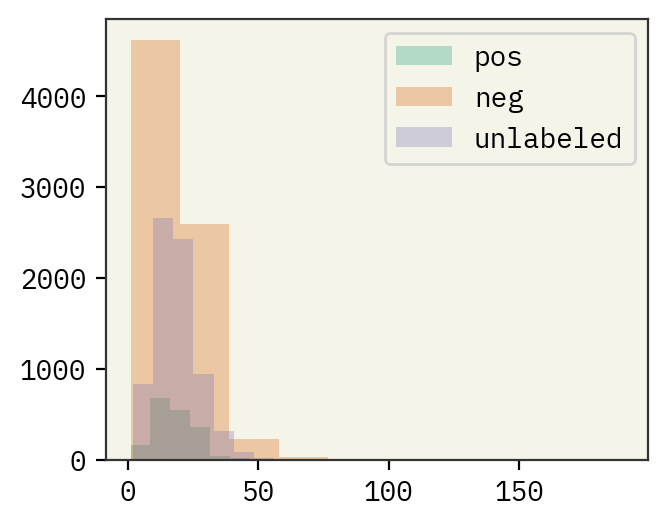

In [9]:
neg_data_lengths = np.count_nonzero(neg_data, axis=1)
unlabeled_data_lengths = np.count_nonzero(sampled_vecs, axis=1)
pos_data_lengths = np.count_nonzero(pos_data, axis=1)

plt.figure(dpi=200)
plt.hist(pos_data_lengths, label='pos', alpha=0.3)
plt.hist(neg_data_lengths, label='neg',alpha=0.3)
plt.hist(unlabeled_data_lengths, label='unlabeled', alpha=0.3)
plt.legend()

In [10]:
print(min(pos_data_lengths), min(neg_data_lengths), min(unlabeled_data_lengths))
print(max(pos_data_lengths), max(neg_data_lengths), max(unlabeled_data_lengths))

1 1 2
77 190 79


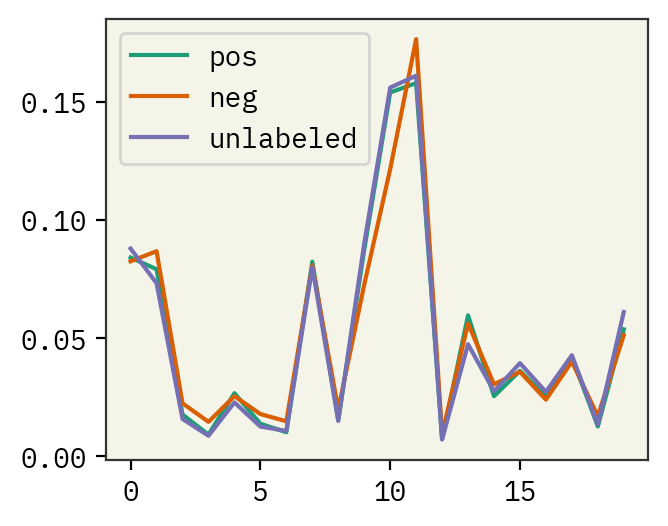

In [11]:
## AA frequencies
plt.figure(dpi=200)
plt.plot(counts_aa(pos_data), label='pos')
plt.plot(counts_aa(neg_data), label='neg')
plt.plot(counts_aa(sampled_vecs), label='unlabeled')
plt.legend()

In [12]:
def split_train_test_data(pos, neg, unlabeled, test_size_pos=0.1, val_size=0.1, unlabeled_size=0.2, seed=None):
    np.random.seed(seed)
    np.random.shuffle(pos)
    np.random.shuffle(neg)
    np.random.shuffle(unlabeled)
    from sklearn.model_selection import train_test_split
#     pos, unlabeled_p, _, _ = train_test_split(pos, np.ones(pos.shape[0]),
#                                                                         test_size=unlabeled_size, random_state=seed)
#     X_test_negative, unlabeled_n, _, _ = train_test_split(neg, np.zeros(neg.shape[0]),
#                                                                     test_size=unlabeled_size, random_state=seed)
    X_test_negative = neg
    X_train_positive, X_test_positive, _, _ = train_test_split(pos, np.ones(pos.shape[0]),
                                                                                        test_size=test_size_pos, random_state=seed)
    X_train_positive, X_val_positive, _, _ = train_test_split(X_train_positive, np.ones(X_train_positive.shape[0]),
                                                                                    test_size=val_size, random_state=seed)
    X_unlabeled = unlabeled
    
    print(X_train_positive.shape, X_val_positive.shape, X_test_positive.shape, X_test_negative.shape,  X_unlabeled.shape)
    return X_train_positive, X_val_positive, X_test_positive, X_test_negative, X_unlabeled

seed = 0
X_train_positive, X_val_positive, X_test_positive, X_test_negative, X_unlabeled = split_train_test_data(pos_data, neg_data, sampled_vecs, seed=seed)

print('Positive data:', pos_data.shape[0])
print('Negative data:', neg_data.shape[0])
print('Unlabeled data:', len(X_unlabeled))

(1478, 190) (165, 190) (183, 190) (7490, 190) (7295, 190)
Positive data: 1826
Negative data: 7490
Unlabeled data: 7295


In [13]:
@dataclass
class Config:
    vocab_size: int
    example_number: int
    batch_size: int
    buffer_size: int
    rnn_units: int
    hidden_dim: int
    embedding_dim: int
    reg_strength: float
    lr: float
    drop_rate: float
        
config = Config(vocab_size=21, # include gap
                example_number=len(pos_data), 
                batch_size=256, 
                buffer_size=10000,
                rnn_units=64,
                hidden_dim=64,
                embedding_dim=32,
                reg_strength=0,
                lr=1e-3,
                drop_rate=0.2
               )

def counts_aa(vec):
    counts =  tf.histogram_fixed_width(vec, [0, 20], nbins=21)[1:]
    return counts/tf.reduce_sum(counts)

def build_model(L):
    inputs = tf.keras.Input(shape=(L,))
    input_f = tf.keras.Input(shape=(20,))
    # make embedding and indicate that 0 should be treated as padding mask
    e = tf.keras.layers.Embedding(input_dim=config.vocab_size, 
                                        output_dim=config.embedding_dim,
                                        mask_zero=True)(inputs)

    # RNN layer
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units, return_sequences=True))(e)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units))(x)
    x = tf.keras.layers.Concatenate()([x, input_f])
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # a dense hidden layer
    x = tf.keras.layers.Dense(
        config.hidden_dim, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    x = tf.keras.layers.Dense(
        config.hidden_dim // 4, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # predicting prob, so no activation
    yhat = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[inputs, input_f], outputs=yhat, name='hemo-rnn')
    return model

class F1Score(tf.keras.metrics.Metric):
  def __init__(self, name='F1Score', **kwargs):
    super(F1Score, self).__init__(name=name, **kwargs)
    self.f1score = self.add_weight(name='F1Score', initializer='zeros')
    self.count = self.add_weight(name='F1ScoreCount', initializer='zeros')

  def update_state(self, y_true, y_pred, sample_weight=None):
    import keras.backend as K
    y_true = tf.cast(y_true, tf.bool)
    y_pred = tf.cast(y_pred, tf.bool)

    true_positives = tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, True))
    true_positives = tf.cast(true_positives, self.dtype)
    count_true_positives = tf.reduce_sum(true_positives)

    possible_positives = tf.cast(y_true, self.dtype)
    count_possible_positives = tf.reduce_sum(possible_positives)

    predicted_positives = tf.cast(y_pred, self.dtype)
    count_predicted_positives = tf.reduce_sum(predicted_positives)

    precision = count_true_positives / (count_predicted_positives + K.epsilon())
    recall = count_true_positives / (count_possible_positives + K.epsilon())
    f1_cal = 2*(precision*recall)/(precision + recall + K.epsilon())

    self.count.assign_add(1)
    a = 1.0 / self.count
    b = 1.0 - a
    self.f1score.assign(a*f1_cal+b*self.f1score)

  def result(self):
    return self.f1score

In [14]:
def spy(X_p, X_u, spied_rate=0.2, seed=None):
    np.random.seed(seed)
    X = np.vstack([X_p, X_u])
    y = np.concatenate([np.ones(X_p.shape[0]), np.zeros(X_u.shape[0])])
    # Step 1. Infuse spies
    spie_mask = np.random.random(X_p.shape[0]) < spied_rate
    # Unknown mix + spies
    MS = np.vstack([X[y == 0], X[y == 1][spie_mask]]) # this is actual features for mix+spies
    MS_spies = np.hstack([np.zeros((y == 0).sum()), np.ones(spie_mask.sum())]) # this is actual labels for mix+spies
    # Positive with spies removed
    P = X[y == 1][~spie_mask]
    # Combo
    MSP = np.vstack([MS, P]) # this is mix+spies added to positives
    # Labels
    MSP_y = np.hstack([np.zeros(MS.shape[0]), np.ones(P.shape[0])]) # this label for is mix+spies added to positives
    shuffler = np.random.permutation(len(MSP))
    MSP = MSP[shuffler]
    MSP_y = MSP_y[shuffler]
    return MSP, MSP_y, MS, MS_spies

def find_RN_threshold(y_hat, y, initial_t=0.00001, added_t=0.0001 , spied_tolerance= 0.025):
    # Find optimal t
    t = initial_t
    while  y[np.squeeze(y_hat <= t)].sum()/y.sum()  <= spied_tolerance:
        t += added_t
    print('Optimal t is {0:.06}'.format(t))
    print('Positive group size {1}, captured spies {0:.02%}'.format(
        y[np.squeeze(y_hat > t)].sum()/y.sum(), (y_hat > t).sum()))
    print('Likely negative group size {1}, captured spies {0:.02%}'.format(
        y[np.squeeze(y_hat <= t)].sum()/y.sum(), (y_hat <= t).sum()))
    return t

(array([7295.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1478.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

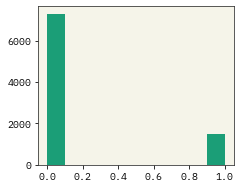

In [15]:
def pad_zeros(x, max_length=200):
    padded_zeros = np.zeros((x.shape[0], max_length-x.shape[1]))
    x = np.concatenate([x, padded_zeros], axis=1)
    return x

if X_unlabeled.shape[1] != X_train_positive.shape[1]:
    X_unlabeled= pad_zeros(X_unlabeled, max_length=X_train_positive.shape[1])

X = np.vstack([X_train_positive, X_unlabeled])
y = np.concatenate([np.ones(X_train_positive.shape[0]), np.zeros(X_unlabeled.shape[0])])
plt.hist(y)

(array([7591.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1182.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

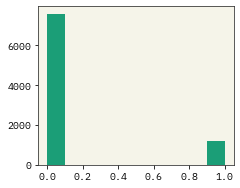

In [16]:
# np.random.seed(seed)
spied_rate = 0.2
X_train_with_spies, y_train_with_spies, true_X_train, true_y_train = spy(X_train_positive, X_unlabeled,
                                                                     seed=seed, spied_rate=spied_rate)
model = build_model(None)
plt.hist(y_train_with_spies)

In [17]:
def train_model(X_train_with_spies, y_train_with_spies, batch_size=64, L=None):
    model = build_model(L)
    decay_epochs = 50
    decay_steps = len(X_train_with_spies)  // 16 * decay_epochs
    lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
          config.lr, decay_steps, alpha=1e-3)
    opt = tf.optimizers.Adam(lr_decayed_fn)
    tf.keras.backend.clear_session()
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='auc', patience=10, min_delta=1e-2, restore_best_weights=True)
    focal_loss  = tf.keras.losses.BinaryFocalCrossentropy(
                gamma=5, from_logits=False,  apply_class_balancing=True
                )
    model.compile(
            optimizer=opt,
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            # loss = focal_loss,
            metrics=[tf.keras.metrics.AUC(from_logits=False), tf.keras.metrics.BinaryAccuracy(threshold=0.5)],
            )
    print(f'\n\nModel l inputs with spies: Negative:{plt.hist(y_train_with_spies)[0][0]}, Positive:{plt.hist(y_train_with_spies)[0][-1]}\n\n')
    history = model.fit(
        [X_train_with_spies, np.array([counts_aa(xi) for xi in X_train_with_spies])] , y_train_with_spies,
#         validation_data=([X_test_L, np.array([counts_aa(xi) for xi in X_test_L])] , y_test_L),
        epochs=200,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=1,
    )
    return model

In [18]:
def get_rn_unlabeled(y_prob, y_actual, rn_thresh, X):
    """For each negative instance, check if the predicted probability
    is lower than the rn threshold. If so, add to the rn set, otherwise,
    add to the unlabelled set.
    Parameters
    ----------
    y_prob: array-like {n_samples}
        Class probability predictions.
    y_actual: array-like {n_samples}
        Actual labelled class values.
    rn_thresh: float
        The threshold under which an instance is
        considered reliably negative.
    X: array-like {n_samples, n_features}
        Feature matrix.
    Returns
    -------
    rn_set: array-like {n_samples, n_features}
        The identified reliable negative instance set.
    new_unlabelled: array-like {n_samples, n_features}
        The remaining unlabelled instances.
    """

    rn_set = [X[i] for i in range(len(X)) if y_actual[i] == 0 and y_prob[i] < rn_thresh]
    new_unlabelled = [X[i] for i in range(len(X)) if y_actual[i] == 0 and y_prob[i] >= rn_thresh]

    return np.array(rn_set), np.array(new_unlabelled)



Model l inputs with spies: Negative:7591.0, Positive:1182.0


Epoch 1/200
138/138 [==============================] - 15s 15ms/step - loss: 0.4194 - auc: 0.5331 - binary_accuracy: 0.8560
Epoch 2/200
138/138 [==============================] - 2s 15ms/step - loss: 0.3894 - auc: 0.6185 - binary_accuracy: 0.8644
Epoch 3/200
138/138 [==============================] - 2s 15ms/step - loss: 0.3660 - auc: 0.7011 - binary_accuracy: 0.8662
Epoch 4/200
138/138 [==============================] - 2s 15ms/step - loss: 0.3487 - auc: 0.7437 - binary_accuracy: 0.8662
Epoch 5/200
138/138 [==============================] - 2s 15ms/step - loss: 0.3400 - auc: 0.7663 - binary_accuracy: 0.8653
Epoch 6/200
138/138 [==============================] - 2s 15ms/step - loss: 0.3290 - auc: 0.7877 - binary_accuracy: 0.8695
Epoch 7/200
138/138 [==============================] - 2s 15ms/step - loss: 0.3173 - auc: 0.8092 - binary_accuracy: 0.8703
Epoch 8/200
138/138 [==============================] - 2s 15ms/step - loss

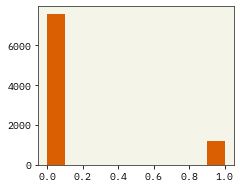

In [19]:
training = True
if training:
    model = train_model(X_train_with_spies, y_train_with_spies, batch_size=64)
    y_hat = model.predict([true_X_train, np.array([counts_aa(xi) for xi in true_X_train])])


In [20]:
def get_rn_unlabeled(y_prob, y_actual, rn_thresh, X, sort=False):
    """For each negative instance, check if the predicted probability
    is lower than the rn threshold. If so, add to the rn set, otherwise,
    add to the unlabelled set.
    Parameters
    ----------
    y_prob: array-like {n_samples}
        Class probability predictions.
    y_actual: array-like {n_samples}
        Actual labelled class values.
    rn_thresh: float
        The threshold under which an instance is
        considered reliably negative.
    X: array-like {n_samples, n_features}
        Feature matrix.
    Returns
    -------
    rn_set: array-like {n_samples, n_features}
        The identified reliable negative instance set.
    new_unlabelled: array-like {n_samples, n_features}
        The remaining unlabelled instances.
    """
    if sort:
        sorted_indices = np.argsort(y_prob,axis=0)
        y_prob = y_prob[sorted_indices]
        y_actual = y_actual[sorted_indices]
    rn_set = [X[i] for i in range(len(X)) if y_actual[i] == 0 and y_prob[i] < rn_thresh]
    new_unlabelled = [X[i] for i in range(len(X)) if y_actual[i] == 0 and y_prob[i] >= rn_thresh]

    return np.array(rn_set), np.array(new_unlabelled)


spied_tolerance = 0.05
RN_t = find_RN_threshold(y_hat, true_y_train, spied_tolerance=spied_tolerance, initial_t=0.000001, added_t=0.000001)
RN , new_X_unlabeled = get_rn_unlabeled(y_hat, true_y_train, RN_t, true_X_train,  sort=True)
print(f'Unlabeled :{X_unlabeled.shape[0]}')
print(f'Pos :{X_train_positive.shape[0]}')
print(f'RNs: {RN.shape[0]}')

Optimal t is 0.004428
Positive group size 3191, captured spies 94.93%
Likely negative group size 4400, captured spies 5.07%
Unlabeled :7295
Pos :1478
RNs: 4385


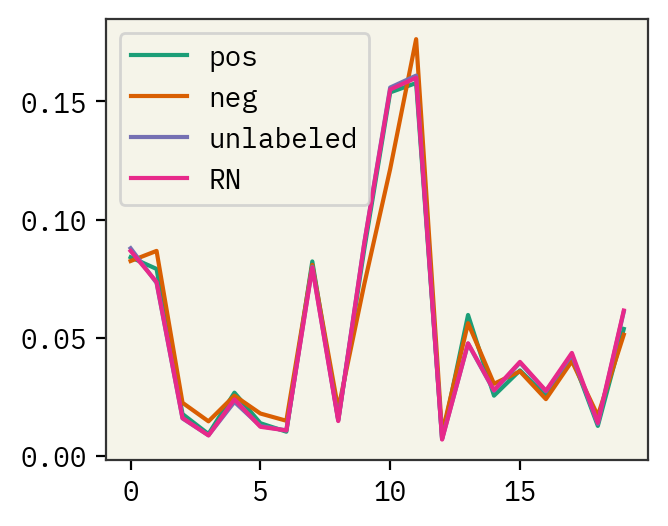

In [21]:
## AA frequencies
plt.figure(dpi=200)
plt.plot(counts_aa(pos_data), label='pos')
plt.plot(counts_aa(neg_data), label='neg')
plt.plot(counts_aa(sampled_vecs), label='unlabeled')
plt.plot(counts_aa(RN), label='RN')
plt.legend()

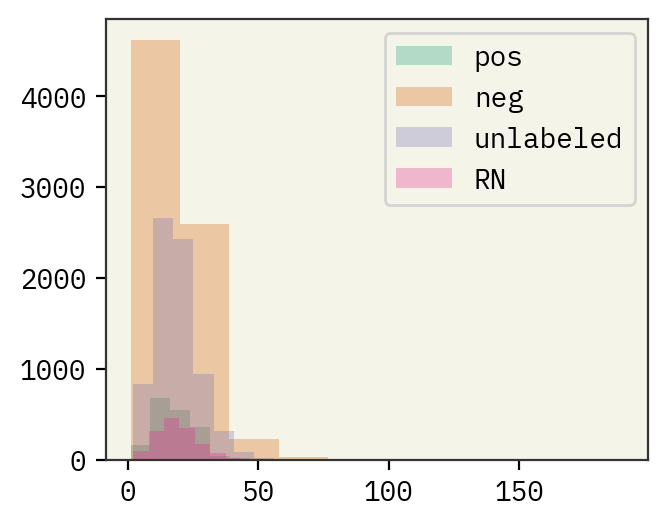

In [22]:
sub_RN = RN[:X_train_positive.shape[0]*1]
RN_lengths = np.count_nonzero(sub_RN, axis=1)

plt.figure(dpi=200)
plt.hist(pos_data_lengths, label='pos', alpha=0.3)
plt.hist(neg_data_lengths, label='neg',alpha=0.3)
plt.hist(unlabeled_data_lengths, label='unlabeled', alpha=0.3)
plt.hist(RN_lengths, label='RN', alpha=0.3)
plt.legend()



Model l inputs with spies: Negative:4385.0, Positive:1478.0


Epoch 1/200
92/92 [==============================] - 13s 16ms/step - loss: 0.5805 - auc: 0.5536 - binary_accuracy: 0.7435
Epoch 2/200
92/92 [==============================] - 1s 16ms/step - loss: 0.5349 - auc: 0.6562 - binary_accuracy: 0.7595
Epoch 3/200
92/92 [==============================] - 1s 16ms/step - loss: 0.5077 - auc: 0.7187 - binary_accuracy: 0.7590
Epoch 4/200
92/92 [==============================] - 1s 16ms/step - loss: 0.4803 - auc: 0.7593 - binary_accuracy: 0.7800
Epoch 5/200
92/92 [==============================] - 1s 16ms/step - loss: 0.4627 - auc: 0.7836 - binary_accuracy: 0.7890
Epoch 6/200
92/92 [==============================] - 1s 16ms/step - loss: 0.4399 - auc: 0.8066 - binary_accuracy: 0.8047
Epoch 7/200
92/92 [==============================] - 1s 16ms/step - loss: 0.4365 - auc: 0.8138 - binary_accuracy: 0.8045
Epoch 8/200
92/92 [==============================] - 1s 16ms/step - loss: 0.4232 - auc: 

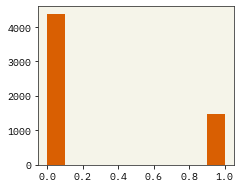

In [23]:

sub_RN = RN[:X_train_positive.shape[0]*5]
NP = np.concatenate([sub_RN, X_train_positive])
Labels = np.concatenate([np.zeros(sub_RN.shape[0]), np.ones(X_train_positive.shape[0])])
train_shuffled_indices = np.random.permutation(len(NP))
NP = NP[train_shuffled_indices]
Labels = Labels[train_shuffled_indices]
inference_model = train_model(NP, Labels, batch_size=64)

In [28]:
# # serialize model to JSON
# inference_model_json = inference_model.to_json()
# with open("../saved_models/hemo-rnn/spy_model_sampling.json", "w") as json_file:
#     json_file.write(inference_model_json)
# # serialize weights to HDF5
# inference_model.save_weights("../saved_models/hemo-rnn/spy_model_weights_sampling.h5")
# # saving RNs
# np.save('../saved_models/hemo-rnn/spy_RNs_sampling.npy', RN)

In [24]:
# spied_tolerance = 0.2
# RN_t = find_RN_threshold(y_hat, true_y_train, spied_tolerance=spied_tolerance, initial_t=0.001)
# RN , new_X_unlabeled = get_rn_unlabeled(y_hat, true_y_train, RN_t, true_X_train)
# NP = np.concatenate([RN, X_train_positive])
# Labels = np.concatenate([np.zeros(RN.shape[0]), np.ones(X_train_positive.shape[0])])
# train_shuffled_indices = np.random.permutation(len(NP))
# NP = NP[train_shuffled_indices]
# Labels = Labels[train_shuffled_indices]
# inference_model = train_model(NP, Labels)

In [25]:
X_test = np.concatenate([X_test_positive, X_test_negative])
y_test = np.concatenate([np.ones(X_test_positive.shape[0]), np.zeros(X_test_negative.shape[0])])
yhat_test =  inference_model.predict([X_test, np.array([counts_aa(xi) for xi in X_test])])

240/240 [==============================] - 5s 5ms/step


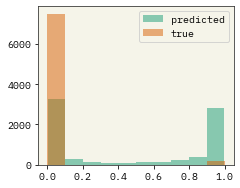

In [26]:
plt.hist(yhat_test, label='predicted', alpha=0.5, bins=10)
plt.hist(y_test, label='true', alpha=0.5, bins=10)
plt.legend()

Best Threshold=0.932385, G-Mean=0.710
Accuracy: 0.685
F1 Score: 0.454
AUC: 0.738


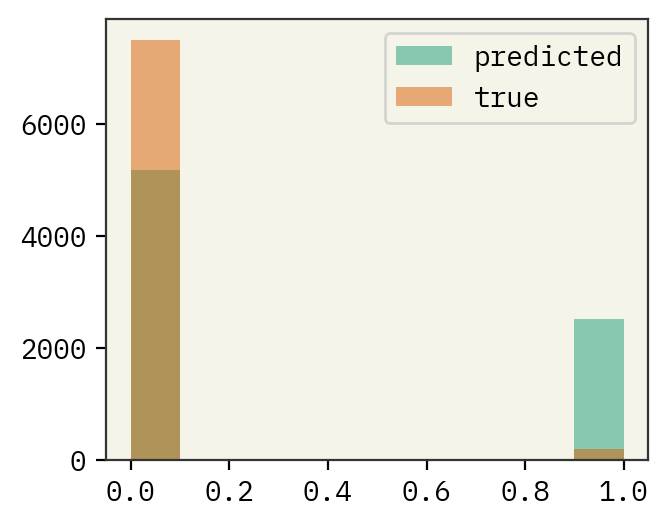

In [27]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

fpr, tpr, thresholds = roc_curve(y_test, yhat_test, drop_intermediate=False)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
best_accuracy_threshold = thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
adjusted_y_hat_test = [1 if m>best_accuracy_threshold else 0 for m in yhat_test]
acc = accuracy_score(y_test, adjusted_y_hat_test, normalize=True)
print(f'Accuracy: {acc:.3f}')
f1 = f1_score(y_test, adjusted_y_hat_test, average='macro')
print(f'F1 Score: {f1:.3f}')
auc = roc_auc_score(y_test, yhat_test, average='macro')
print(f'AUC: {auc:.3f}')
plt.figure(dpi=200)
plt.hist(adjusted_y_hat_test, label='predicted', alpha=0.5, bins=10)
plt.hist(y_test, label='true', alpha=0.5, bins=10)
plt.legend()


Best ghostml Threshold=%f, 0.94
Accuracy: 0.696
F1 Score: 0.459
AUC: 0.738


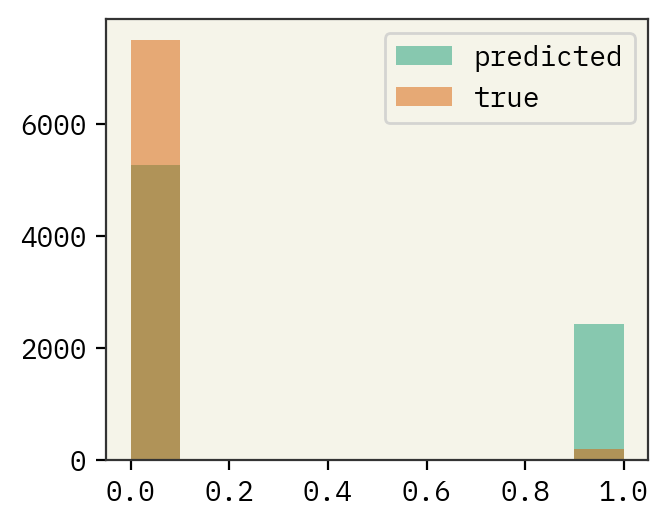

In [29]:
import ghostml
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# train_probs = model_2.predict([NP, np.array([counts_aa(xi) for xi in NP])])
thresholds = np.round(np.arange(0.1,0.95,0.005),2)
threshold1 = ghostml.optimize_threshold_from_predictions(y_test, yhat_test[:,0], thresholds, ThOpt_metrics = 'Kappa')
print(f'\nBest ghostml Threshold=%f, {threshold1}')
best_accuracy_threshold = threshold1
adjusted_y_hat_test = [1 if m>best_accuracy_threshold else 0 for m in yhat_test]
acc = accuracy_score(y_test, adjusted_y_hat_test, normalize=True)
print(f'Accuracy: {acc:.3f}')
f1 = f1_score(y_test, adjusted_y_hat_test, average='macro')
print(f'F1 Score: {f1:.3f}')
auc = roc_auc_score(y_test, yhat_test, average='macro')
print(f'AUC: {auc:.3f}')

plt.figure(dpi=200)
plt.hist(adjusted_y_hat_test, label='predicted', alpha=0.5, bins=10)
plt.hist(y_test, label='true', alpha=0.5, bins=10)
plt.legend()